In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quandl
import fbprophet
import pytrends
from pytrends.request import TrendReq
import matplotlib
exchange='WIKI'
ticker='AMZN'

df = quandl.get('%s/%s' % (exchange, ticker),api_key='xCpdYQzqjxgooYJ7zisz')
stock=df.copy()
data=df.copy()

In [15]:
stock=df.copy()

In [16]:

# Symbol is used for labeling plots
symbol = ticker
# Set the index to a column called Date
stock = stock.reset_index(level=0)

# Columns required for prophet
stock['ds'] = stock['Date']

if ('Adj. Close' not in stock.columns):
    stock['Adj. Close'] = stock['Close']
    stock['Adj. Open'] = stock['Open']

stock['y'] = stock['Adj. Close']
stock['Daily Change'] = stock['Adj. Close'] - stock['Adj. Open']

# Minimum and maximum date in range
min_date = min(stock['Date'])
max_date = max(stock['Date'])

# Find max and min prices and dates on which they occurred
max_price = np.max(stock['y'])
min_price = np.min(stock['y'])

min_price_date = stock[stock['y'] == min_price]['Date']
min_price_date = min_price_date[min_price_date.index[0]]
max_price_date = stock[stock['y'] == max_price]['Date']
max_price_date = max_price_date[max_price_date.index[0]]

# The starting price (starting with the opening price)
starting_price = float(stock.ix[0, 'Adj. Open'])

# The most recent price
most_recent_price = float(stock.ix[len(stock) - 1, 'y'])

# Whether or not to round dates
round_dates = True

# Number of years of data to train on
training_years = 3

# Prophet parameters
# Default prior from library
changepoint_prior_scale = 0.05 
weekly_seasonality = False
daily_seasonality = False
monthly_seasonality = True
yearly_seasonality = True
changepoints = None

print('{} Stocker Initialized. Data covers {} to {}.'.format(symbol,
                                                             min_date.date(),
                                                             max_date.date()))





AMZN Stocker Initialized. Data covers 1997-05-16 to 2018-03-27.


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [17]:
def handle_dates( start_date, end_date):
    # Default start and end date are the beginning and end of data
    if start_date is None:
        start_date = min_date
    if end_date is None:
        end_date = max_date
    # Convert to pandas datetime for indexing dataframe
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    return start_date, end_date

def make_df( start_date, end_date, df=None):
    # Default is to use the object stock data
    if not df:
        df = stock.copy()
    start_date, end_date = handle_dates(start_date, end_date)
    trim_df = df[(df['Date'] >= start_date.date()) & 
                 (df['Date'] <= end_date.date())]
    return trim_df

# Reset the plotting parameters to clear style formatting
def reset_plot():

    # Restore default parameters
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    # Adjust a few parameters to liking
    matplotlib.rcParams['figure.figsize'] = (8, 5)
    matplotlib.rcParams['axes.labelsize'] = 10
    matplotlib.rcParams['xtick.labelsize'] = 8
    matplotlib.rcParams['ytick.labelsize'] = 8
    matplotlib.rcParams['axes.titlesize'] = 14
    matplotlib.rcParams['text.color'] = 'k'


def plot_stock( start_date=None, end_date=None, stats=['Adj. Close'], plot_type='basic'):
    reset_plot()
    if start_date is None:
        start_date = min_date
    if end_date is None:
        end_date = max_date
    stock_plot = make_df(start_date, end_date)
    colors = ['r', 'b', 'g', 'y', 'c', 'm']
    for i, stat in enumerate(stats):
        stat_min = min(stock_plot[stat])
        stat_max = max(stock_plot[stat])
        stat_avg = np.mean(stock_plot[stat])
        date_stat_min = stock_plot[stock_plot[stat] == stat_min]['Date']
        date_stat_min = date_stat_min[date_stat_min.index[0]].date()
        date_stat_max = stock_plot[stock_plot[stat] == stat_max]['Date']
        date_stat_max = date_stat_max[date_stat_max.index[0]].date()

        print('Maximum {} = {:.2f} on {}.'.format(stat, stat_max, date_stat_max))
        print('Minimum {} = {:.2f} on {}.'.format(stat, stat_min, date_stat_min))
        print('Current {} = {:.2f} on {}.\n'.format(stat, stock.ix[len(stock) - 1, stat], max_date.date()))

        # Percentage y-axis
        if plot_type == 'pct':
            # Simple Plot 
            plt.style.use('fivethirtyeight');
            if stat == 'Daily Change':
                plt.plot(stock_plot['Date'], 100 * stock_plot[stat],
                     color = colors[i], linewidth = 2.4, alpha = 0.9,
                     label = stat)
            else:
                plt.plot(stock_plot['Date'], 100 * (stock_plot[stat] -  stat_avg) / stat_avg,
                     color = colors[i], linewidth = 2.4, alpha = 0.9,
                     label = stat)

            plt.xlabel('Date'); plt.ylabel('Change Relative to Average (%)'); plt.title('%s Stock History' % symbol); 
            plt.legend(prop={'size':10})
            plt.grid(color = 'k', alpha = 0.4); 

        # Stat y-axis
        elif plot_type == 'basic':
            plt.style.use('fivethirtyeight');
            plt.plot(stock_plot['Date'], stock_plot[stat], color = colors[i], linewidth = 3, label = stat, alpha = 0.8)
            plt.xlabel('Date'); plt.ylabel('US $'); plt.title('%s Stock History' % symbol); 
            plt.legend(prop={'size':10})
            plt.grid(color = 'k', alpha = 0.4); 

    plt.show();



Maximum Adj. Close = 1598.39 on 2018-03-12.
Minimum Adj. Close = 1.40 on 1997-05-22.
Current Adj. Close = 1497.05 on 2018-03-27.



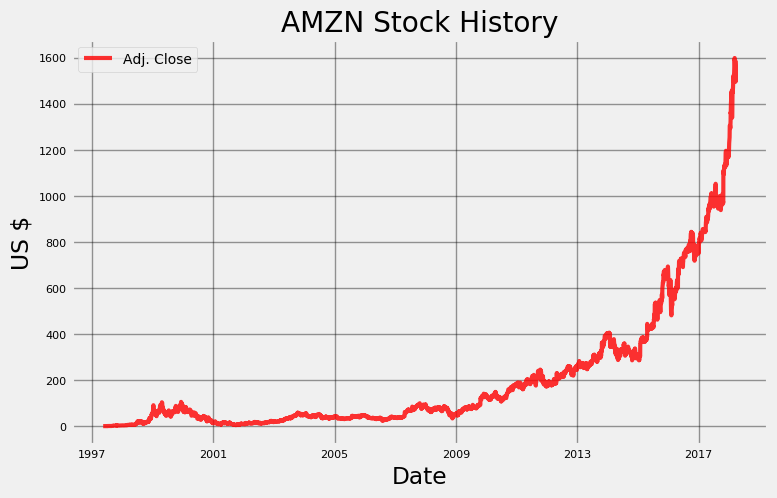

In [18]:
plot_stock()

In [23]:
# Method to linearly interpolate prices on the weekends
def resample( dataframe):
    # Change the index and resample at daily level
    dataframe = dataframe.set_index('ds')
    dataframe = dataframe.resample('D')
    # Reset the index and interpolate nan values
    dataframe = dataframe.reset_index(level=0)
    dataframe = dataframe.interpolate()
    return dataframe

# Remove weekends from a dataframe
def remove_weekends( dataframe):
    # Reset index to use ix
    dataframe = dataframe.reset_index(drop=True)
    weekends = []
    # Find all of the weekends
    for i, date in enumerate(dataframe['ds']):
        if (date.weekday()) == 5 | (date.weekday() == 6):
            weekends.append(i)
    # Drop the weekends
    dataframe = dataframe.drop(weekends, axis=0)
    return dataframe

# Create a prophet model without training
def create_model():
    # Make the model
    model = fbprophet.Prophet(daily_seasonality=daily_seasonality,  
                              weekly_seasonality=weekly_seasonality, 
                              yearly_seasonality=yearly_seasonality,
                              changepoint_prior_scale=changepoint_prior_scale,
                              changepoints=changepoints)

    if monthly_seasonality:
        # Add monthly seasonality
        model.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
    return model

# Basic prophet model for specified number of days  
def create_prophet_model( days=0, resample=False):
    reset_plot()
    model = create_model()

    # Fit on the stock history for training_years number of years
    stock_history1 = stock[stock['Date'] > (max_date - pd.DateOffset(years = training_years)).date()]
    stock_history=stock_history1[stock_history1['Date'] < (max_date - pd.DateOffset(years = 1)).date()]
    if resample:
        stock_history = resample(stock_history)
    model.fit(stock_history)

    # Make and predict for next year with future dataframe
    future = model.make_future_dataframe(periods = days, freq='D')
    future = model.predict(future)
    if days > 0:
        # Print the predicted price
        print('Predicted Price on {} = ${:.2f}'.format(
            future.ix[len(future) - 1, 'ds'].date(), future.ix[len(future) - 1, 'yhat']))

        title = '%s Historical and Predicted Stock Price'  % symbol
    else:
        title = '%s Historical and Modeled Stock Price' % symbol

    # Set up the plot
    fig, ax = plt.subplots(1, 1)
    # Plot the actual values
    ax.plot(stock_history1['ds'], stock_history1['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
    # Plot the actual values
    
    #ax.plot(stock[stock['Date'] < (max_date - pd.DateOffset(years = 1)).date()]['ds'], stock[stock['Date'] < (max_date - pd.DateOffset(years = 1)).date()]['y'], 'r', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
    # Plot the predicted values
    ax.plot(future['ds'], future['yhat'], 'forestgreen',linewidth = 2.4, label = 'Modeled');
    # Plot the uncertainty interval as ribbon
    ax.fill_between(future['ds'].dt.to_pydatetime(), future['yhat_upper'], future['yhat_lower'], alpha = 0.3, 
                   facecolor = 'g', edgecolor = 'k', linewidth = 1.4, label = 'Confidence Interval')

    # Plot formatting
    plt.legend(loc = 2, prop={'size': 10}); plt.xlabel('Date'); plt.ylabel('Price $');
    plt.grid(linewidth=0.6, alpha = 0.6)
    plt.title(title);
    plt.show()

    return model, future



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Predicted Price on 2018-03-24 = $1185.99


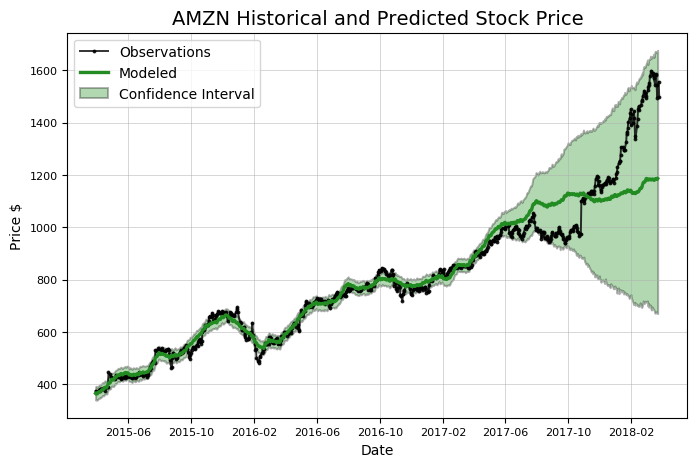

In [24]:
model,future=create_prophet_model(days=365)

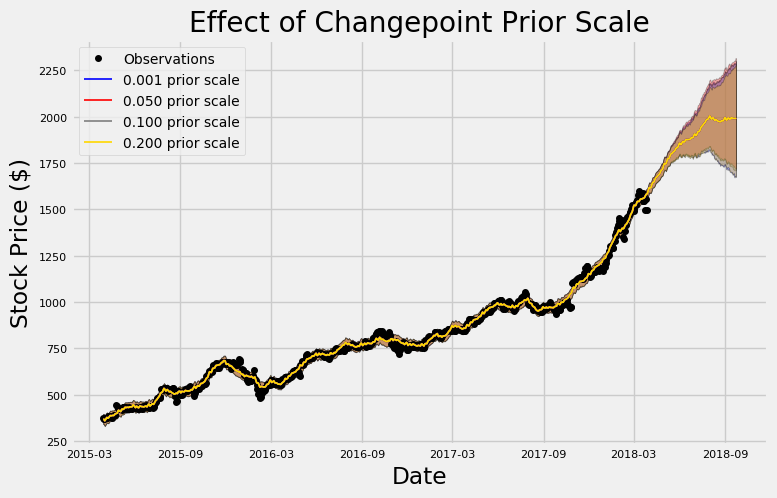

In [25]:
# Graph the effects of altering the changepoint prior scale (cps)
def changepoint_prior_analysis( changepoint_priors=[0.001, 0.05, 0.1, 0.2], colors=['b', 'r', 'grey', 'gold']):

    # Training and plotting with specified years of data
    train = stock[(stock['Date'] > (max(stock['Date']) - pd.DateOffset(years=training_years)).date())]

    # Iterate through all the changepoints and make models
    for i, prior in enumerate(changepoint_priors):
        # Select the changepoint
        changepoint_prior_scale = prior

        # Create and train a model with the specified cps
        model = create_model()
        model.fit(train)
        future = model.make_future_dataframe(periods=180, freq='D')

        # Make a dataframe to hold predictions
        if i == 0:
            predictions = future.copy()

        future = model.predict(future)

        # Fill in prediction dataframe
        predictions['%.3f_yhat_upper' % prior] = future['yhat_upper']
        predictions['%.3f_yhat_lower' % prior] = future['yhat_lower']
        predictions['%.3f_yhat' % prior] = future['yhat']

    # Remove the weekends
    #predictions = remove_weekends(predictions)

    # Plot set-up
    reset_plot()
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(1, 1)

    # Actual observations
    ax.plot(train['ds'], train['y'], 'ko', ms = 4, label = 'Observations')
    color_dict = {prior: color for prior, color in zip(changepoint_priors, colors)}

    # Plot each of the changepoint predictions
    for prior in changepoint_priors:
        # Plot the predictions themselves
        ax.plot(predictions['ds'], predictions['%.3f_yhat' % prior], linewidth = 1.2,
                 color = color_dict[prior], label = '%.3f prior scale' % prior)

        # Plot the uncertainty interval
        ax.fill_between(predictions['ds'].dt.to_pydatetime(), predictions['%.3f_yhat_upper' % prior],
                        predictions['%.3f_yhat_lower' % prior], facecolor = color_dict[prior],
                        alpha = 0.3, edgecolor = 'k', linewidth = 0.6)

    # Plot labels
    plt.legend(loc = 2, prop={'size': 10})
    plt.xlabel('Date'); plt.ylabel('Stock Price ($)'); plt.title('Effect of Changepoint Prior Scale');
    plt.show()
changepoint_prior_analysis()


Validation Range 2016-03-28 to 2017-03-27.



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


     cps  train_err  train_range    test_err  test_range
0  0.001  14.413078    47.842694  142.970866  225.477004
1  0.050  14.413078    47.911130  142.970866  237.896129
2  0.100  14.413078    47.841800  142.970866  225.482638
3  0.200  14.413078    47.892172  142.970866  231.024323


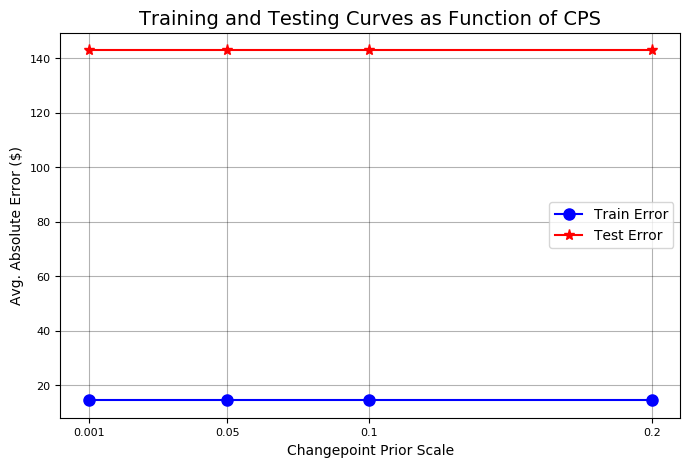

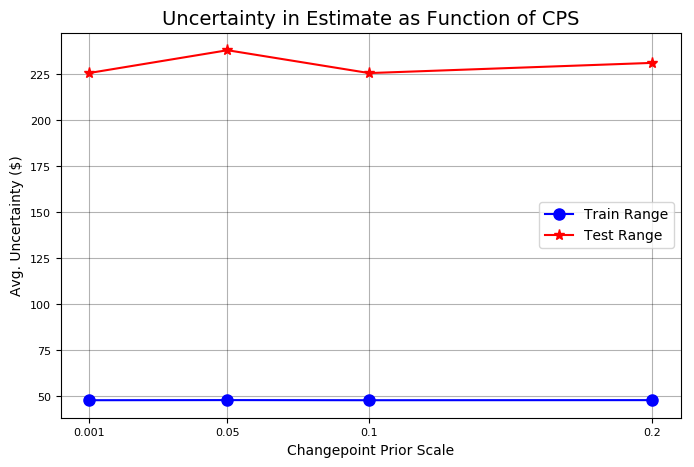

In [26]:
def changepoint_prior_validation( start_date=None, end_date=None,changepoint_priors = [0.001, 0.05, 0.1, 0.2]):


    # Default start date is two years before end of data
    # Default end date is one year before end of data
    if start_date is None:
        start_date = max_date - pd.DateOffset(years=2)
    if end_date is None:
        end_date = max_date - pd.DateOffset(years=1)

    # Convert to pandas datetime for indexing dataframe
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    start_date, end_date = handle_dates(start_date, end_date)

    # Select training_years number of years
    train = stock[(stock['Date'] > (start_date - pd.DateOffset(years=training_years)).date()) & 
    (stock['Date'] < start_date.date())]

    # Testing data is specified by range
    test = stock[(stock['Date'] >= start_date.date()) & (stock['Date'] <= end_date.date())]

    eval_days = (max(test['Date']).date() - min(test['Date']).date()).days

    results = pd.DataFrame(0, index = list(range(len(changepoint_priors))), 
        columns = ['cps', 'train_err', 'train_range', 'test_err', 'test_range'])

    print('\nValidation Range {} to {}.\n'.format(min(test['Date']).date(),
        max(test['Date']).date()))


    # Iterate through all the changepoints and make models
    for i, prior in enumerate(changepoint_priors):
        results.ix[i, 'cps'] = prior

        # Select the changepoint
        changepoint_prior_scale = prior

        # Create and train a model with the specified cps
        model = create_model()
        model.fit(train)
        future = model.make_future_dataframe(periods=eval_days, freq='D')

        future = model.predict(future)

        # Training results and metrics
        train_results = pd.merge(train, future[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], on = 'ds', how = 'inner')
        avg_train_error = np.mean(abs(train_results['y'] - train_results['yhat']))
        avg_train_uncertainty = np.mean(abs(train_results['yhat_upper'] - train_results['yhat_lower']))

        results.ix[i, 'train_err'] = avg_train_error
        results.ix[i, 'train_range'] = avg_train_uncertainty

        # Testing results and metrics
        test_results = pd.merge(test, future[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], on = 'ds', how = 'inner')
        avg_test_error = np.mean(abs(test_results['y'] - test_results['yhat']))
        avg_test_uncertainty = np.mean(abs(test_results['yhat_upper'] - test_results['yhat_lower']))

        results.ix[i, 'test_err'] = avg_test_error
        results.ix[i, 'test_range'] = avg_test_uncertainty

    print(results)



    # Plot of training and testing average errors
    reset_plot()

    plt.plot(results['cps'], results['train_err'], 'bo-', ms = 8, label = 'Train Error')
    plt.plot(results['cps'], results['test_err'], 'r*-', ms = 8, label = 'Test Error')
    plt.xlabel('Changepoint Prior Scale'); plt.ylabel('Avg. Absolute Error ($)');
    plt.title('Training and Testing Curves as Function of CPS')
    plt.grid(color='k', alpha=0.3)
    plt.xticks(results['cps'], results['cps'])
    plt.legend(prop={'size':10})
    plt.show();

    # Plot of training and testing average uncertainty
    reset_plot()

    plt.plot(results['cps'], results['train_range'], 'bo-', ms = 8, label = 'Train Range')
    plt.plot(results['cps'], results['test_range'], 'r*-', ms = 8, label = 'Test Range')
    plt.xlabel('Changepoint Prior Scale'); plt.ylabel('Avg. Uncertainty ($)');
    plt.title('Uncertainty in Estimate as Function of CPS')
    plt.grid(color='k', alpha=0.3)
    plt.xticks(results['cps'], results['cps'])
    plt.legend(prop={'size':10})
    plt.show();
changepoint_prior_validation()

In [10]:
changepoint_priors=[0.001, 0.05, 0.1, 0.2]
train = stock[(stock['Date'] > (max(stock['Date']) - pd.DateOffset(years=training_years)).date())]

# Iterate through all the changepoints and make models
for i, prior in enumerate(changepoint_priors):
    # Select the changepoint
    changepoint_prior_scale = prior

    # Create and train a model with the specified cps
    model = create_model()
    model.fit(train)
    future = model.make_future_dataframe(periods=180, freq='D')

    # Make a dataframe to hold predictions
    if i == 0:
        predictions = future.copy()

    future = model.predict(future)

    # Fill in prediction dataframe
    predictions['%.3f_yhat_upper' % prior] = future['yhat_upper']
    predictions['%.3f_yhat_lower' % prior] = future['yhat_lower']
    predictions['%.3f_yhat' % prior] = future['yhat']
print predictions


             ds  0.001_yhat_upper  0.001_yhat_lower   0.001_yhat  \
0    2014-03-28        294.197085         64.095237   173.699535   
1    2014-03-31        276.956058         50.956618   163.466667   
2    2014-04-01        280.895055         39.993801   160.684489   
3    2014-04-02        282.306042         39.353582   162.157629   
4    2014-04-03        280.384277         59.404616   165.459724   
5    2014-04-04        284.551638         52.603218   166.087640   
6    2014-04-07        269.423382         36.821246   149.880130   
7    2014-04-08        264.121551         26.432449   150.992644   
8    2014-04-09        269.173023         46.399166   156.618574   
9    2014-04-10        282.178475         42.716322   161.867540   
10   2014-04-11        278.818713         42.041576   162.641524   
11   2014-04-14        275.590069         39.819516   155.313706   
12   2014-04-15        274.327493         42.495154   159.199260   
13   2014-04-16        285.834024         36.498

In [ ]:
# Evaluate prediction model for one year
def evaluate_prediction( start_date=None, end_date=None, nshares = None):

    # Default start date is one year before end of data
    # Default end date is end date of data
    if start_date is None:
        start_date = max_date - pd.DateOffset(years=1)
    if end_date is None:
        end_date = max_date

    start_date, end_date = handle_dates(start_date, end_date)

    # Training data starts training_years years before start date and goes up to start date
    train = stock[(stock['Date'] < start_date.date()) & 
                       (stock['Date'] > (start_date - pd.DateOffset(years=training_years)).date())]

    # Testing data is specified in the range
    test = stock[(stock['Date'] >= start_date.date()) & (stock['Date'] <= end_date.date())]

    # Create and train the model
    model = create_model()
    model.fit(train)

    # Make a future dataframe and predictions
    future = model.make_future_dataframe(periods = 365, freq='D')
    future = model.predict(future)

    # Merge predictions with the known values
    test = pd.merge(test, future, on = 'ds', how = 'inner')

    train = pd.merge(train, future, on = 'ds', how = 'inner')

    # Calculate the differences between consecutive measurements
    test['pred_diff'] = test['yhat'].diff()
    test['real_diff'] = test['y'].diff()

    # Correct is when we predicted the correct direction
    test['correct'] = (np.sign(test['pred_diff']) == np.sign(test['real_diff'])) * 1

    # Accuracy when we predict increase and decrease
    increase_accuracy = 100 * np.mean(test[test['pred_diff'] > 0]['correct'])
    decrease_accuracy = 100 * np.mean(test[test['pred_diff'] < 0]['correct'])

    # Calculate mean absolute error
    test_errors = abs(test['y'] - test['yhat'])
    test_mean_error = np.mean(test_errors)

    train_errors = abs(train['y'] - train['yhat'])
    train_mean_error = np.mean(train_errors)

    # Calculate percentage of time actual value within prediction range
    test['in_range'] = False

    for i in test.index:
        if (test.ix[i, 'y'] < test.ix[i, 'yhat_upper']) & (test.ix[i, 'y'] > test.ix[i, 'yhat_lower']):
            test.ix[i, 'in_range'] = True

    in_range_accuracy = 100 * np.mean(test['in_range'])

    if not nshares:
        # Date range of predictions
        print('\nPrediction Range: {} to {}.'.format(start_date.date(),
            end_date.date()))

        # Final prediction vs actual value
        print('\nPredicted price on {} = ${:.2f}.'.format(max(future['ds']).date(), future.ix[len(future) - 1, 'yhat']))
        print('Actual price on    {} = ${:.2f}.\n'.format(max(test['ds']).date(), test.ix[len(test) - 1, 'y']))

        print('Average Absolute Error on Training Data = ${:.2f}.'.format(train_mean_error))
        print('Average Absolute Error on Testing  Data = ${:.2f}.\n'.format(test_mean_error))

        # Direction accuracy
        print('When the model predicted an increase, the price increased {:.2f}% of the time.'.format(increase_accuracy))
        print('When the model predicted a  decrease, the price decreased  {:.2f}% of the time.\n'.format(decrease_accuracy))

        print('The actual value was within the {:d}% confidence interval {:.2f}% of the time.'.format(int(100 * model.interval_width), in_range_accuracy))

        raw_input()
         # Reset the plot
        reset_plot()

        # Set up the plot
        fig, ax = plt.subplots(1, 1)

        # Plot the actual values
        ax.plot(train['ds'], train['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
        ax.plot(test['ds'], test['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')

        # Plot the predicted values
        ax.plot(future['ds'], future['yhat'], 'navy', linewidth = 2.4, label = 'Predicted');

        # Plot the uncertainty interval as ribbon
        ax.fill_between(future['ds'].dt.to_pydatetime(), future['yhat_upper'], future['yhat_lower'], alpha = 0.6, 
                       facecolor = 'gold', edgecolor = 'k', linewidth = 1.4, label = 'Confidence Interval')

        # Put a vertical line at the start of predictions
        plt.vlines(x=min(test['ds']).date(), ymin=min(future['yhat_lower']), ymax=max(future['yhat_upper']), colors = 'r',
                   linestyles='dashed', label = 'Prediction Start')

        # Plot formatting
        plt.legend(loc = 2, prop={'size': 8}); plt.xlabel('Date'); plt.ylabel('Price $');
        plt.grid(linewidth=0.6, alpha = 0.6)

        plt.title('{} Model Evaluation from {} to {}.'.format(symbol,
            start_date.date(), end_date.date()));
        plt.show();

    # If a number of shares is specified, play the game
    elif nshares:

        # Only playing the stocks when we predict the stock will increase
        test_pred_increase = test[test['pred_diff'] > 0]

        test_pred_increase.reset_index(inplace=True)
        prediction_profit = []

        # Iterate through all the predictions and calculate profit from playing
        for i, correct in enumerate(test_pred_increase['correct']):

            # If we predicted up and the price goes up, we gain the difference
            if correct == 1:
                prediction_profit.append(nshares * test_pred_increase.ix[i, 'real_diff'])
            # If we predicted up and the price goes down, we lose the difference
            else:
                prediction_profit.append(nshares * test_pred_increase.ix[i, 'real_diff'])

        test_pred_increase['pred_profit'] = prediction_profit

        # Put the profit into the test dataframe
        test = pd.merge(test, test_pred_increase[['ds', 'pred_profit']], on = 'ds', how = 'left')
        test.ix[0, 'pred_profit'] = 0

        # Profit for either method at all dates
        test['pred_profit'] = test['pred_profit'].cumsum().ffill()
        test['hold_profit'] = nshares * (test['y'] - float(test.ix[0, 'y']))

        # Display information
        print('You played the stock market in {} from {} to {} with {} shares.\n'.format(
            symbol, start_date.date(), end_date.date(), nshares))

        print('When the model predicted an increase, the price increased {:.2f}% of the time.'.format(increase_accuracy))
        print('When the model predicted a  decrease, the price decreased  {:.2f}% of the time.\n'.format(decrease_accuracy))

        # Display some friendly information about the perils of playing the stock market
        print('The total profit using the Prophet model = ${:.2f}.'.format(np.sum(prediction_profit)))
        print('The Buy and Hold strategy profit =         ${:.2f}.'.format(float(test.ix[len(test) - 1, 'hold_profit'])))
        print('\nThanks for playing the stock market!\n')



        # Plot the predicted and actual profits over time
        reset_plot()

        # Final profit and final smart used for locating text
        final_profit = test.ix[len(test) - 1, 'pred_profit']
        final_smart = test.ix[len(test) - 1, 'hold_profit']

        # text location
        last_date = test.ix[len(test) - 1, 'ds']
        text_location = (last_date - pd.DateOffset(months = 1)).date()

        plt.style.use('dark_background')

        # Plot smart profits
        plt.plot(test['ds'], test['hold_profit'], 'b',
                 linewidth = 1.8, label = 'Buy and Hold Strategy') 

        # Plot prediction profits
        plt.plot(test['ds'], test['pred_profit'], 
                 color = 'g' if final_profit > 0 else 'r',
                 linewidth = 1.8, label = 'Prediction Strategy')

        # Display final values on graph
        plt.text(x = text_location, 
                 y =  final_profit + (final_profit / 40),
                 s = '$%d' % final_profit,
                color = 'g' if final_profit > 0 else 'r',
                size = 18)

        plt.text(x = text_location, 
                 y =  final_smart + (final_smart / 40),
                 s = '$%d' % final_smart,
                color = 'g' if final_smart > 0 else 'r',
                size = 18);

        # Plot formatting
        plt.ylabel('Profit  (US $)'); plt.xlabel('Date'); 
        plt.title('Predicted versus Buy and Hold Profits');
        plt.legend(loc = 2, prop={'size': 10});
        plt.grid(alpha=0.2); 
        plt.show()

# Predict the future price for a given range of days
def predict_future( days=30):

    # Use past training_years years for training
    train = stock[stock['Date'] > (max(stock['Date']) - pd.DateOffset(years=training_years)).date()]

    model = create_model()

    model.fit(train)

    # Future dataframe with specified number of days to predict
    future = model.make_future_dataframe(periods=days, freq='D')
    future = model.predict(future)

    # Only concerned with future dates
    future = future[future['ds'] >= max(stock['Date']).date()]

    # Remove the weekends
    #future = remove_weekends(future)

    # Calculate whether increase or not
    future['diff'] = future['yhat'].diff()

    future = future.dropna()

    # Find the prediction direction and create separate dataframes
    future['direction'] = (future['diff'] > 0) * 1

    # Rename the columns for presentation
    future = future.rename(columns={'ds': 'Date', 'yhat': 'estimate', 'diff': 'change', 
                                    'yhat_upper': 'upper', 'yhat_lower': 'lower'})

    future_increase = future[future['direction'] == 1]
    future_decrease = future[future['direction'] == 0]

    # Print out the dates
    print('\nPredicted Increase: \n')
    print(future_increase[['Date', 'estimate', 'change', 'upper', 'lower']])

    print('\nPredicted Decrease: \n')
    print(future_decrease[['Date', 'estimate', 'change', 'upper', 'lower']])

    reset_plot()

    # Set up plot
    plt.style.use('fivethirtyeight')
    matplotlib.rcParams['axes.labelsize'] = 10
    matplotlib.rcParams['xtick.labelsize'] = 8
    matplotlib.rcParams['ytick.labelsize'] = 8
    matplotlib.rcParams['axes.titlesize'] = 12

    # Plot the predictions and indicate if increase or decrease
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Plot the estimates
    ax.plot(future_increase['Date'], future_increase['estimate'], 'g^', ms = 12, label = 'Pred. Increase')
    ax.plot(future_decrease['Date'], future_decrease['estimate'], 'rv', ms = 12, label = 'Pred. Decrease')

    # Plot errorbars
    ax.errorbar(future['Date'].dt.to_pydatetime(), future['estimate'], 
                yerr = future['upper'] - future['lower'], 
                capthick=1.4, color = 'k',linewidth = 2,
               ecolor='darkblue', capsize = 4, elinewidth = 1, label = 'Pred with Range')

    # Plot formatting
    plt.legend(loc = 2, prop={'size': 10});
    plt.xticks(rotation = '45')
    plt.ylabel('Predicted Stock Price (US $)');
    plt.xlabel('Date'); plt.title('Predictions for %s' % symbol);
    plt.show()

def changepoint_prior_validation( start_date=None, end_date=None,changepoint_priors = [0.001, 0.05, 0.1, 0.2]):


    # Default start date is two years before end of data
    # Default end date is one year before end of data
    if start_date is None:
        start_date = max_date - pd.DateOffset(years=2)
    if end_date is None:
        end_date = max_date - pd.DateOffset(years=1)

    # Convert to pandas datetime for indexing dataframe
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    start_date, end_date = handle_dates(start_date, end_date)

    # Select training_years number of years
    train = stock[(stock['Date'] > (start_date - pd.DateOffset(years=training_years)).date()) & 
    (stock['Date'] < start_date.date())]

    # Testing data is specified by range
    test = stock[(stock['Date'] >= start_date.date()) & (stock['Date'] <= end_date.date())]

    eval_days = (max(test['Date']).date() - min(test['Date']).date()).days

    results = pd.DataFrame(0, index = list(range(len(changepoint_priors))), 
        columns = ['cps', 'train_err', 'train_range', 'test_err', 'test_range'])

    print('\nValidation Range {} to {}.\n'.format(min(test['Date']).date(),
        max(test['Date']).date()))


    # Iterate through all the changepoints and make models
    for i, prior in enumerate(changepoint_priors):
        results.ix[i, 'cps'] = prior

        # Select the changepoint
        changepoint_prior_scale = prior

        # Create and train a model with the specified cps
        model = create_model()
        model.fit(train)
        future = model.make_future_dataframe(periods=eval_days, freq='D')

        future = model.predict(future)

        # Training results and metrics
        train_results = pd.merge(train, future[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], on = 'ds', how = 'inner')
        avg_train_error = np.mean(abs(train_results['y'] - train_results['yhat']))
        avg_train_uncertainty = np.mean(abs(train_results['yhat_upper'] - train_results['yhat_lower']))

        results.ix[i, 'train_err'] = avg_train_error
        results.ix[i, 'train_range'] = avg_train_uncertainty

        # Testing results and metrics
        test_results = pd.merge(test, future[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], on = 'ds', how = 'inner')
        avg_test_error = np.mean(abs(test_results['y'] - test_results['yhat']))
        avg_test_uncertainty = np.mean(abs(test_results['yhat_upper'] - test_results['yhat_lower']))

        results.ix[i, 'test_err'] = avg_test_error
        results.ix[i, 'test_range'] = avg_test_uncertainty

    print(results)



    # Plot of training and testing average errors
    reset_plot()

    plt.plot(results['cps'], results['train_err'], 'bo-', ms = 8, label = 'Train Error')
    plt.plot(results['cps'], results['test_err'], 'r*-', ms = 8, label = 'Test Error')
    plt.xlabel('Changepoint Prior Scale'); plt.ylabel('Avg. Absolute Error ($)');
    plt.title('Training and Testing Curves as Function of CPS')
    plt.grid(color='k', alpha=0.3)
    plt.xticks(results['cps'], results['cps'])
    plt.legend(prop={'size':10})
    plt.show();

    # Plot of training and testing average uncertainty
    reset_plot()

    plt.plot(results['cps'], results['train_range'], 'bo-', ms = 8, label = 'Train Range')
    plt.plot(results['cps'], results['test_range'], 'r*-', ms = 8, label = 'Test Range')
    plt.xlabel('Changepoint Prior Scale'); plt.ylabel('Avg. Uncertainty ($)');
    plt.title('Uncertainty in Estimate as Function of CPS')
    plt.grid(color='k', alpha=0.3)
    plt.xticks(results['cps'], results['cps'])
    plt.legend(prop={'size':10})
    plt.show();